In [7]:
### mount on google drive
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/WatNet/notebooks")
# !pip install rasterio


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
import os
os.chdir('..')
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.tiff_io import readTiff, writeTiff
from utils.acc_pixel import acc_matrix
from utils.imgPatch import imgPatch
from model.seg_model.watnet import watnet
from model.seg_model.deeplabv3_plus import deeplabv3_plus
from model.seg_model.deepwatermapv2 import deepwatermapv2

In [16]:
## test image and test sample
path_S2_img = 'data/test-data(demo)/T49QGF_20191017_6Bands_Urban_Subs.tif'
path_sam = 'data/test-data(demo)/val_sam.csv'
# pre-trained model
path_model = 'model/pretrained/deepwatmapv2.h5'
path_result_map = 'data/test-data(demo)/result_map_2.tif'
## super parameters
patch_size = 512
overlay = 80  # the overlay area between neighboring patches

In [ ]:
# ## test image and test sample
# path_S2_img = 'data/test-data/T49QGF_20191017T025709_6Bands_Urban.tif'
# path_sam = 'data/test-data/val_sam_cloudy.csv'
# # pre-trained model
# path_model = 'model/pretrained/watnet.h5'
# path_result_map = 'result/result_urban_deeplabv3plus.tif'
# ## super parameters
# patch_size = 512
# overlay = 80  # the overlay area between neighboring patches


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:1061: UserWarning: model.seg_model.deepwatermapv2 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


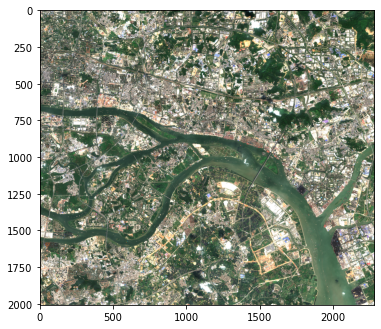

In [17]:
# Load and prepare the satellite image data
#################################################################
img_src, sen2_img = readTiff(path_in=path_S2_img)
sen2_img = np.float32(np.clip(sen2_img/10000, a_min=0, a_max=1))  ## normalization
plt.figure(figsize=(6,6))
plt.imshow(sen2_img[:, :, (2,1,0)]*5)
###  load the pretrained model
# model = keras.models.load_model(path_model, custom_objects={'tf': tf}, compile=False)
# model.summary()


In [20]:
###  load the pretrained model
# model = watnet(input_shape=(512, 512, 6), nclasses=2)
# model = deeplabv3_plus(nclasses=2, input_shape=(512, 512, 6))
model = deepwatermapv2(min_width=4)
model.load_weights(path_model)


In [21]:
## surface water mapping from sentinel-2 image
with tf.device('/device:CPU:0'):
    imgPatch_ins = imgPatch(sen2_img, patch_size, overlay)
    patch_list, start_list, img_patch_row, img_patch_col = imgPatch_ins.toPatch()
    result_patch_list = [model(patch[np.newaxis, :]) for patch in patch_list]
    result_patch_list = [np.squeeze(patch, axis = 0) for patch in result_patch_list]
    pro_map = imgPatch_ins.toImage(result_patch_list, img_patch_row, img_patch_col)
    cla_map = np.where(pro_map>0.5, 1, 0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


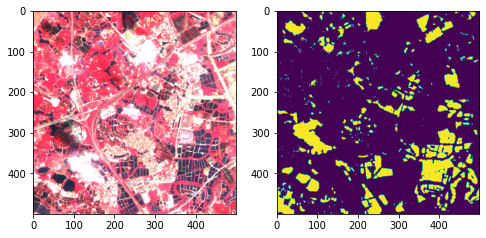

In [23]:
### show the result
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sen2_img[1500:2000, 1000:1500, (3,2,1)]*6.5)
plt.subplot(1,2,2)
plt.imshow(cla_map[1500:2000, 1000:1500, 0])


OA: 0.9635
Producer acc: 1.0
user acc: 1.0
Confusion matrix: [[241  18]
 [  0 234]]


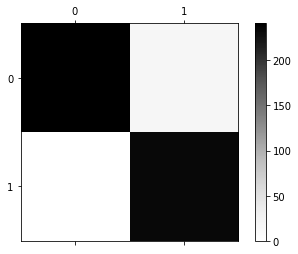

In [24]:
## show the accuracy
df_sam = pd.read_csv(path_sam, header=0)
acc_oa, acc_prod, acc_user, confus_mat = acc_matrix(cla_map, df_sam.to_numpy(), id_label=0)
print('OA:', acc_oa)
print('Producer acc:', acc_prod)
print('user acc:', acc_user)
print('Confusion matrix:', np.around(confus_mat,4))
plt.matshow(confus_mat,cmap=plt.cm.Greys, fignum=0)
plt.colorbar()



In [ ]:
## save the result
# writeTiff(cla_map[:,:,0], im_geotrans, im_proj, path_result_map)
